# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Терёшина".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_j} = - \frac{ e^{-y^{(i)} g(x^{(i)}) } }{1 + e^{-y^{(i)} g(x^{(i)})}} \cdot y^{(i)}x_j^{(i)} + \frac{2}{C}w_j$$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=100, random_state=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.random_state = random_state
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        X = np.c_[np.ones((X.shape[0], 1)), X]
        y = (y - 0.5)*2 # [0, 1] -> [-1, 1]

        # начальное приближение
        np.random.seed(self.random_state)
        self.w = np.random.random(X.shape[1])
        self.loss = np.empty(self.max_epoch)
        
        eps = 1e-5
        
        n = int((X.shape[0] + self.batch_size) / self.batch_size)
        
        for i in range(self.max_epoch):
            X, y = shuffle(X, y)
            w = self.w.copy()
            
            for j in range(0, n):                
                batch = np.arange(j * self.batch_size, min((j + 1) * self.batch_size, X.shape[0]))
                grad = self._stoch_gradient_descent(X[batch], y[batch])
                self.w = self.w - grad*self.alpha/(1 + i)
                
            #if np.sum(np.absolute(np.subtract(self.w, w))) < eps:
            #    break
                
            #self.loss[i] = np.sum(np.log(1 + np.power(np.e, (-y*X.dot(self.w)))))
            self.loss[i] = np.mean(np.log(1 + np.exp(-y*X.dot(self.w)))) + 1.0 / self.C * np.sum(self.w**2)
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[np.ones((X.shape[0], 1)), X]
        y_hat = np.sign(X.dot(self.w))/2.0 + 0.5 # [-1, 1] -> [0, 1]
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        
        y_hat_proba = 1.0 - 1.0/(1.0 + np.exp(-X.dot(self.w)))
        
        return y_hat_proba
    
    def _stoch_gradient_descent(self, X, y):
        
        grad = -np.dot(y/(np.exp(y*X.dot(self.w)) + 1), X) + 2.0/self.C*self.w
        
        return grad

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

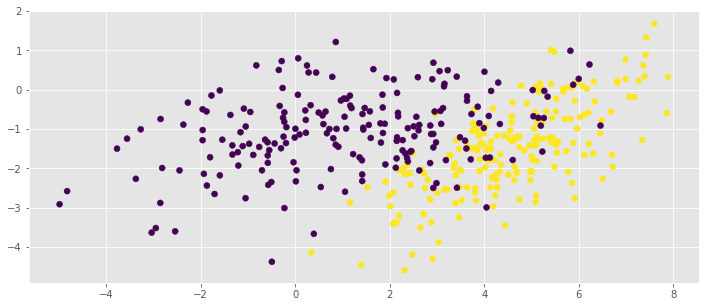

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
model = MySGDClassifier(max_epoch=60, C=100, batch_size=32, alpha=0.04)
model.fit(X, y)

w = model.w

In [6]:
w

array([-3.71177806,  0.87669048, -0.88033884])

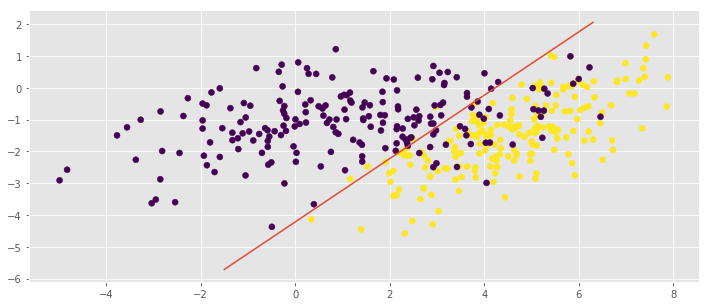

In [7]:
plt.scatter(X[:,0], X[:,1], c=y)
x = np.array([-1.5, 6.3])
plt.plot(x, -w[1]/w[2]*x - w[0]/w[2])

plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [8]:
from sklearn.datasets import make_classification

In [9]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

In [10]:
X.shape

(100000, 10)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

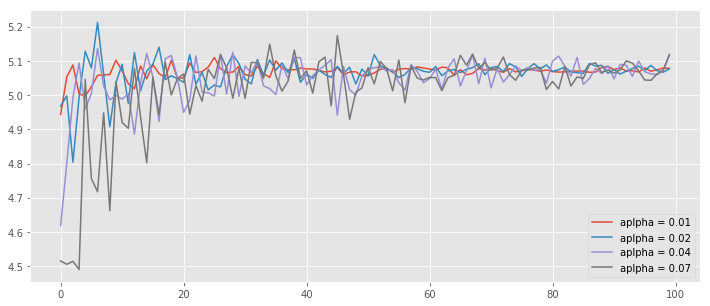

In [11]:
## Your Code Here

a = np.array([0.01, 0.02, 0.04, 0.07])

for alpha in a:
    model = MySGDClassifier(alpha=alpha, max_epoch=100)
    model.fit(X, y)
    loss = model.loss
    
    plt.plot(range(loss.shape[0]), loss, label='aplpha = ' + str(alpha))
    plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [12]:
## Your Code Here

c = np.logspace(3, -3, 10)
x = np.empty((10, 11))
i = 0
for C in c:
    model = MySGDClassifier(C=C)
    model.fit(X, y)
    x[i] = model.w
    i += 1

/home/maria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in exp
/home/maria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply


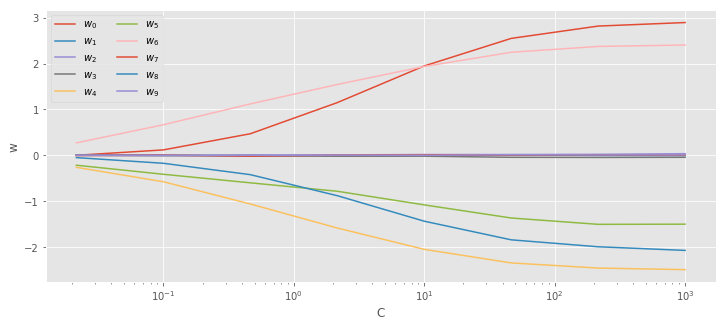

In [13]:
for i in range(0, X.shape[1]):
    plt.plot(c, x[:,i], label='$w_' + str(i) + '$')
    
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('w')
plt.legend(loc = 'upper left', ncol=2)

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [14]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [15]:
df_data.shape

(500000, 45)

In [16]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [17]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [18]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [19]:
## Youd Code Here
print 'У игрока: ', len(df_data['player_hero_card_id'].unique())
print 'У оппонента: ', len(df_data['opponent_hero_card_id'].unique())

У игрока:  9
У оппонента:  9


In [20]:
cat_vars = ['player_hero_card_id', 'opponent_hero_card_id']
data = pd.get_dummies(df_data, columns=cat_vars)

In [21]:
data.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,opponent_deck_count,...,player_hero_card_id_1235,opponent_hero_card_id_25,opponent_hero_card_id_326,opponent_hero_card_id_390,opponent_hero_card_id_494,opponent_hero_card_id_612,opponent_hero_card_id_754,opponent_hero_card_id_798,opponent_hero_card_id_981,opponent_hero_card_id_1235
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346,1,14,0,0,5,0,0,10,10,11,...,0,0,0,0,0,0,0,1,0,0
3270826,1,7,0,0,22,0,0,6,6,19,...,0,0,0,0,0,0,1,0,0,0
3189487,1,5,3,0,29,0,0,4,1,22,...,0,0,0,0,0,1,0,0,0,0
4098946,1,8,0,0,26,0,0,7,7,17,...,0,0,0,1,0,0,0,0,0,0
2661127,0,13,0,0,30,0,0,10,1,12,...,0,1,0,0,0,0,0,0,0,0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [22]:
## Youd Code Here
y = data['decision'].values
X = data.drop('decision', axis=1).values

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [24]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('myclf', MySGDClassifier())])

In [25]:
pipe.fit(X, y)

/home/maria/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('myclf', MySGDClassifier(C=1, alpha=0.01, batch_size=100, max_epoch=10,
        random_state=None))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [26]:
## Youd Code Here
filepath = './testData_tabular/testData_tabular_chunk5.csv'
test_data = pd.read_csv(filepath, sep=',')

In [27]:
test_data.columns = test_data.columns.str.replace('.', '_')
test_data = test_data.set_index('gamestate_id')

In [28]:
test_data = pd.get_dummies(test_data, columns=cat_vars)

In [29]:
X_test = test_data.drop('decision', axis=1).values

In [30]:
y_test = pd.read_csv("./deprecated_testLabels.txt", names=["decision"])["decision"].values[:len(X_test)]

In [31]:
y_hat = pipe.predict(X_test)

In [32]:
from sklearn.metrics import roc_auc_score

In [33]:
roc_auc_score(y_test, y_hat)

0.70012729761131165